### 0. Introduction

In [1]:
# IMPORT LIBRARIES AND DATA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from geopy.geocoders import Nominatim # Might be necessary install Geopy using 'pip install geopy'
from concurrent.futures import ThreadPoolExecutor
from sklearn.neighbors import NearestNeighbors
import plotly.express as px # Might be necessary install  Plotly using 'pip install plotly'
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

data = pd.read_excel("Road Accident Data.xlsx")

### 1. EDA and Preprocessing

In [2]:
print(data.shape)

(307973, 23)


In [3]:
print(data.head())

  Accident_Index Accident Date Month Day_of_Week  Year  \
0  200901BS70001    2021-01-01   Jan    Thursday  2021   
1  200901BS70002    2021-01-05   Jan      Monday  2021   
2  200901BS70003    2021-01-04   Jan      Sunday  2021   
3  200901BS70004    2021-01-05   Jan      Monday  2021   
4  200901BS70005    2021-01-06   Jan     Tuesday  2021   

           Junction_Control          Junction_Detail Accident_Severity  \
0  Give way or uncontrolled  T or staggered junction           Serious   
1  Give way or uncontrolled               Crossroads           Serious   
2  Give way or uncontrolled  T or staggered junction            Slight   
3       Auto traffic signal  T or staggered junction           Serious   
4       Auto traffic signal               Crossroads           Serious   

    Latitude       Light_Conditions  ... Number_of_Casualties  \
0  51.512273               Daylight  ...                    1   
1  51.514399               Daylight  ...                   11   
2  51.48666

In [4]:
print(data.describe())

                       Accident Date           Year       Latitude  \
count                         307973  307973.000000  307973.000000   
mean   2021-12-23 22:19:39.804722944    2021.468934      52.487005   
min              2021-01-01 00:00:00    2021.000000      49.914488   
25%              2021-06-28 00:00:00    2021.000000      51.485248   
50%              2021-12-08 00:00:00    2021.000000      52.225943   
75%              2022-06-25 00:00:00    2022.000000      53.415517   
max              2022-12-31 00:00:00    2022.000000      60.598055   
std                              NaN       0.499035       1.339011   

           Longitude  Number_of_Casualties  Number_of_Vehicles    Speed_limit  
count  307973.000000         307973.000000       307973.000000  307973.000000  
mean       -1.368884              1.356882            1.829063      38.866037  
min        -7.516225              1.000000            1.000000      10.000000  
25%        -2.247937              1.000000       

In [5]:
print(data.dtypes)

Accident_Index                        object
Accident Date                 datetime64[ns]
Month                                 object
Day_of_Week                           object
Year                                   int64
Junction_Control                      object
Junction_Detail                       object
Accident_Severity                     object
Latitude                             float64
Light_Conditions                      object
Local_Authority_(District)            object
Carriageway_Hazards                   object
Longitude                            float64
Number_of_Casualties                   int64
Number_of_Vehicles                     int64
Police_Force                          object
Road_Surface_Conditions               object
Road_Type                             object
Speed_limit                            int64
Time                                  object
Urban_or_Rural_Area                   object
Weather_Conditions                    object
Vehicle_Ty

First of all, we notice that our data has 307.973 samples and 23 columns, which makes our file too heavy and slow to be loaded in some computers. Therefore, a good idea would be transform the file from .xlsx to .parquet, which is another type of file that Pandas finds easier to load.

But for now, we are going to examinate our data to see what preliminary information can we get from it.

Firstly, let's see if there are any NaNs in our data.

In [6]:
print("Total number of NaNs: " + str(data.isna().sum().sum()) + "\n")

print("Percentage of NaNs by column:\n\n" + str(data.isna().sum().sort_values()/len(data)*100) + "\n\n")

Total number of NaNs: 310474

Percentage of NaNs by column:

Accident_Index                 0.000000
Urban_or_Rural_Area            0.000000
Speed_limit                    0.000000
Police_Force                   0.000000
Number_of_Vehicles             0.000000
Number_of_Casualties           0.000000
Longitude                      0.000000
Local_Authority_(District)     0.000000
Light_Conditions               0.000000
Vehicle_Type                   0.000000
Accident_Severity              0.000000
Junction_Detail                0.000000
Junction_Control               0.000000
Year                           0.000000
Day_of_Week                    0.000000
Month                          0.000000
Accident Date                  0.000000
Latitude                       0.000000
Time                           0.005520
Road_Surface_Conditions        0.102931
Road_Type                      0.498096
Weather_Conditions             1.966731
Carriageway_Hazards           98.238807
dtype: float64




In [7]:
np.unique(data[data["Carriageway_Hazards"].notna()]["Carriageway_Hazards"])

array(['Any animal in carriageway (except ridden horse)',
       'Other object on road', 'Pedestrian in carriageway - not injured',
       'Previous accident', 'Vehicle load on road'], dtype=object)

We see that "Carriageway_Hazards" concentrates more than 98% of NaNs, and that can cause a problem, because our models could underestimate the influence of this variable due to its large amount of NaNs.

"A priori", we could think that the objects over the road might have an impact on the severity of the accident, so delete the column can have a negative result.

On the other hand, deleting just the samples that are NaNs would let our dataset with just the 2% of data we currently have, and this sounds even worse. 

Therefore, instead of deleting data, we could consider that a value checked as a "NaN" could just mean that there were no special objects on the road. A prove that backs this hypothesis is that we do not see any "No Object"-like in the unique values of this column (shown just above). So we are going to replace all "NaNs" values of "Carriageway_Hazards" with the label "No object", so we can move forward with no NaNs.

Regarding the presence of NaNs in other columns, their percentage is so low that we can just replace them with their mode or mean.

In [8]:
data["Carriageway_Hazards"].fillna("No object", inplace=True)

for column in data.columns:
    if data[column].isna().sum()>0:
        data[column].fillna(data[column].mode()[0], inplace=True) # We use the mode because all columns with NaNs are categorical

"Time" is an important variable that gives us information about the moments of the day when accidents occur the most. As the dataset comes, this variable is codified as a "datetime" object, showing the exact hour, minute and second when the accident was notified. We would prefer to codify this variable, so it shows the period of the day, rather than the exact time.

In [9]:
"""

Early Morning: from 00:00 to 06:00
Sunrise: from 06:00 to 09:00
Morning: from 09:00 to 12:00
Noon: from 12:00 to 14:00
Afternoon: from 14:00 to 18:00
Sunset: from 18:00 to 19:00
Night: from 19:00 to 00:00

"""

def classify_time(time):
    hour = pd.to_datetime(str(time), format='%H:%M:%S').hour
    if hour >= 0 and hour < 6:
        return 'Early Morning'
    elif hour >= 6 and hour < 9:
        return 'Sunrise'
    elif hour >= 9 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 14:
        return 'Noon'
    elif hour >= 14 and hour < 18:
        return 'Afternoon'
    elif hour >= 18 and hour < 19:
        return 'Sunset'
    else:
        return 'Night'

data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.time

data['Time'] = data['Time'].apply(classify_time)

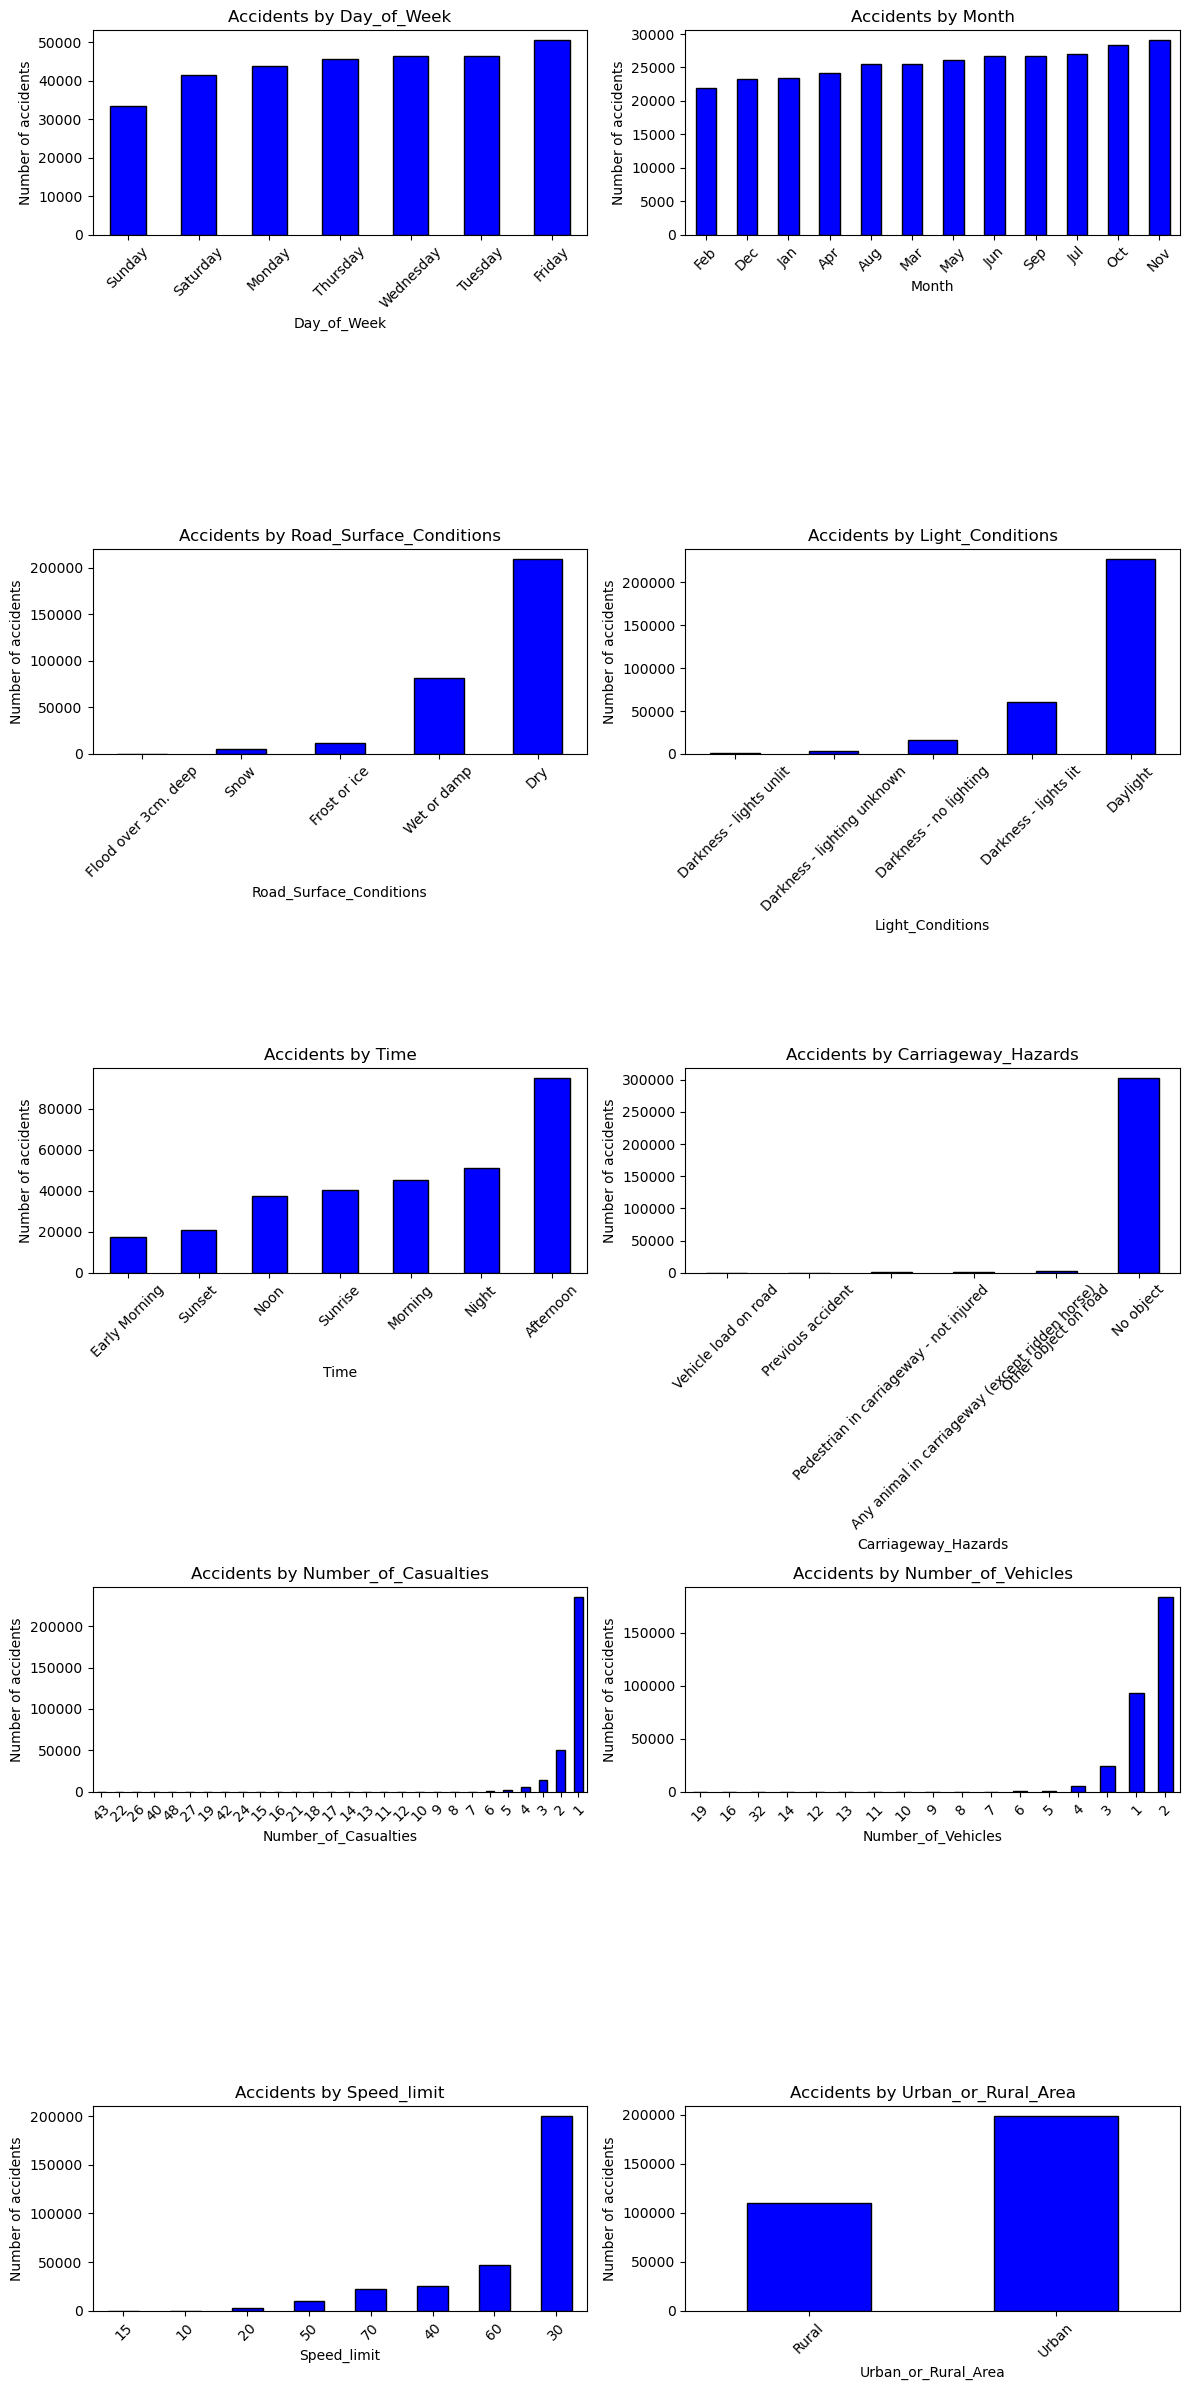

In [12]:
fig, axes = plt.subplots(5, 2, figsize=(12, 24))

variables = ["Day_of_Week", "Month", "Road_Surface_Conditions", "Light_Conditions", "Time", "Carriageway_Hazards",
            "Number_of_Casualties", "Number_of_Vehicles", "Speed_limit", "Urban_or_Rural_Area"]

current_index = 0
for x in range(5):
    for y in range(2):
        tmp = data[variables[current_index]].value_counts()
        tmp.sort_values().plot(kind='bar', color='blue', edgecolor='black', ax=axes[x][y])
        axes[x][y].set_xlabel(variables[current_index])
        axes[x][y].set_ylabel("Number of accidents")
        axes[x][y].set_title("Accidents by " + variables[current_index])
        axes[x][y].tick_params(axis='x', rotation=45)
        current_index+=1

plt.tight_layout()

plt.show()

"Accident_Index" is a code that uniquely identifies each accident within our dataset. It does not give any other information, except for the inaccurate location where the accident took place (the code is composed by numbers and two letters, which could be hardly used to get the city or town), but that information can be extracted from the "Longitude" and "Latitude" variables, so we can definitively omit that variable.

In [13]:
data = data.drop("Accident_Index", axis=1)

Also notice that we only have data from January 1st 2021 to January 1st 2022, so we can not get a relation between the feature "Year" and our target "Accident_Severity". Therefore, we can omit this feature too.

In [14]:
data = data.drop("Year", axis=1)

Furthermore, "Accident Date" column is also redundant, as we already have "Month" and "Day_of_Week" columns. So we can also delete this feature.

In [15]:
data = data.drop("Accident Date", axis=1)

It is important to notice that most of our variables are categorical, except for "Speed_limit" (maximum legal speed of the road where the accident took place), "Latitude" and "Longitude", "Number_of_Casualties" and "Number_of_Vehicles".

Tree-based models are usually better to work with categorial features, but as we said, we also want to prove Neural Networks, so we will have to encode all categorical features.

For now, we are going to extract the location (city) where each accident happened from the longitude and latitude, using GeoNames free database (https://www.geonames.org/) and 1-Nearest Neighbour model from SKLearn. The idea is to load a map of the United Kingdom (from which our data belongs) and filter by a 'feature code' so as to obtain only names of important locations of the UK (excluding famous buildings or geographical places, for instance), and filter those cities with less than 100.000 inhabitants. Once we have the data loaded, we apply Ball Tree algorithm to obtain the closest city name to all latitude-longitude pairs. 

In [16]:
# IMPORT GEOGRAPHICAL DATA

column_names = ["geonameid", "name", "asciiname", "alternatenames", "latitude", "longitude",
                "feature_class", "feature_code", "country_code", "cc2", "admin1_code", 
                "admin2_code", "admin3_code", "admin4_code", "population", "elevation", 
                "dem", "timezone", "modification_date"]

geoData = pd.read_csv("GB.txt", sep="\t", header=None, names=column_names, low_memory=False)

geoData = geoData[(geoData['feature_code'].isin(['PPLC', 'PPLA', 'PPLA2'])) & (geoData['population'] > 100000)]

coords = geoData[['latitude', 'longitude']].to_numpy()

# APPLY BALL TREE

nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(coords)

def get_nearest_location(lat, lon, df, nbrs):
    distance, index = nbrs.kneighbors([[lat, lon]])
    return df.iloc[index[0][0]]['name']

locations = [get_nearest_location(latitude, longitude, geoData, nbrs) for latitude, longitude in zip(data['Latitude'], data['Longitude'])]

data['Location'] = locations

In [18]:
severity_counts = data.groupby(['Location', 'Accident_Severity']).size().unstack(fill_value=0)
plt.figure(figsize=(30, 12))
severity_counts.plot(kind='bar', stacked=False, edgecolor='black', color=['blue', 'orange', 'red'])
plt.xlabel("Location", fontsize=14)
plt.ylabel("Number of accidents", fontsize=14)
plt.title("Accidents by location and severity", fontsize=16)
plt.xticks(rotation=90, ha="center", fontsize=10)
plt.close()
fig = px.bar(severity_counts, barmode='group', color_discrete_sequence=['blue', 'orange', 'red'])
fig.update_layout(
    title="Accidents by location and severity in 2021 in the United Kingdom",
    xaxis_title="Location and severity",
    yaxis_title="Number of accidents",
    xaxis_tickangle=90,
    font=dict(size=14)
)
fig.write_html("accidents_by_location_and_severity.html")
fig.show()

<Figure size 3000x1200 with 0 Axes>

Since we already have our new 'Location' column, we can delete 'Latitude' and 'Longitude' columns.

In [19]:
data.drop(['Latitude', 'Longitude'], axis=1, inplace=True)

Now, it is time to code ordinal categorical variables, those that have values of their domain related by order (including our target).

In [20]:
# Features

days = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
 'Friday': 4, 'Saturday': 5, 'Sunday': 6}

months = {'Jan': 0, 'Feb': 1, 'Mar': 2, 'Apr': 3, 'May': 4, 
 'Jun': 5, 'Jul': 6, 'Aug': 7, 'Sep': 8, 
 'Oct': 9, 'Nov': 10, 'Dec': 11}

time = {'Early Morning': 0, 'Sunrise': 1, 'Morning': 2, 'Noon': 3, 
 'Afternoon': 4, 'Sunset': 5, 'Night': 6}

data["Day_of_Week"] = data["Day_of_Week"].apply(lambda x: days[x])
data["Month"] = data["Month"].apply(lambda x: months[x])
data["Time"] = data["Time"].apply(lambda x: time[x])


# Target

severity = {'Slight': 0, 'Serious': 1, 'Fatal': 2}

data["Accident_Severity"] = data["Accident_Severity"].apply(lambda x: severity[x])

Now, let's codify non-ordinal categorical features using Ordinal Encoder from SKLearn. Ordinal Encoder assigns digits to strings based on the alphabetical order.

In [21]:
encoder = OrdinalEncoder()

Non_Ordinal_Categorical_Features = ["Junction_Control", "Junction_Detail", "Location", "Light_Conditions", 
     "Local_Authority_(District)", "Carriageway_Hazards", "Police_Force", "Road_Surface_Conditions",
     "Road_Type", "Urban_or_Rural_Area", "Weather_Conditions", "Vehicle_Type"]

data[Non_Ordinal_Categorical_Features] = encoder.fit_transform(data[Non_Ordinal_Categorical_Features])

At this moment, when all global preprocessing has been done, we can split our data into train set and test set. And continue preprocessing only the train set, if necessary. Let's use 80% for train and 20% for test, as normal.

In [22]:
X = data.drop("Accident_Severity", axis=1)
y = data["Accident_Severity"]

X_train_o, X_test, y_train_o, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now, let's see how distributed our target is.

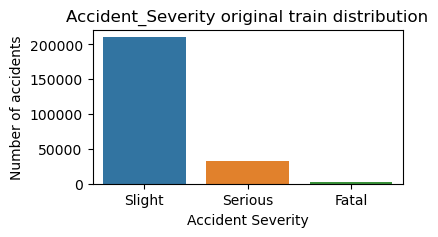

Accident_Severity
0    210617
1     32639
2      3122
Name: count, dtype: int64
Accident_Severity
0    0.854853
1    0.132475
2    0.012672
Name: proportion, dtype: float64


In [26]:
def showTargetDistribution(target):
    plt.figure(figsize=(4, 2))
    sns.countplot(x=target)
    plt.title('Accident_Severity original train distribution')
    plt.ylabel('Number of accidents')
    plt.xlabel("Accident Severity")
    plt.xticks(ticks=[0, 1, 2], labels=['Slight','Serious', 'Fatal'])
    plt.show()

    counts = target.value_counts()
    print(counts)

    proportions = target.value_counts(normalize=True)
    print(proportions)
    
showTargetDistribution(y_train_o)

"Accident_Severity" is not equaly distributed, so we can use SMOTE, which creates new synthetic samples, in order to balance our target.

In [27]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_o, y_train_o)

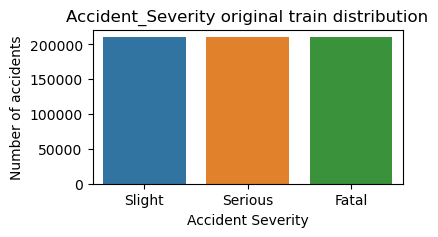

Accident_Severity
0    210617
1    210617
2    210617
Name: count, dtype: int64
Accident_Severity
0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64


In [28]:
showTargetDistribution(y_train)